In [1]:
import pandas as pd
import numpy as np # Import numpy for NaN handling
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.ticker as mticker # For formatting log scale ticks

Successfully loaded data from: .\data_comparison\interpolation_comparison_errors.csv
Original columns: ['Number of Nodes', 'Node Type', 'Interpolation Method', 'Max Error', 'Scaled RMSE']
Data sample:
    Number of Nodes     Node Type                      Interpolation Method  \
0                5  Równoodległe      Zagadnienie Hermite'a (Wzór Newtona)   
1                5    Czebyszewa      Zagadnienie Hermite'a (Wzór Newtona)   
2                5  Równoodległe  Zagadnienie Lagrange'a (Wzór Lagrange'a)   
3                5    Czebyszewa  Zagadnienie Lagrange'a (Wzór Lagrange'a)   
4                5  Równoodległe     Zagadnienie Lagrange'a (Wzór Newtona)   

    Max Error  Scaled RMSE  
0    9.490189     0.159440  
1  182.401083     3.281695  
2   12.342239     0.193710  
3    9.613580     0.153835  
4   12.342239     0.193710  

Columns after renaming and type conversion: ['N', 'Node Type', 'Interpolation Method', 'Max Error', 'Scaled RMSE']
Data types:
 N                         

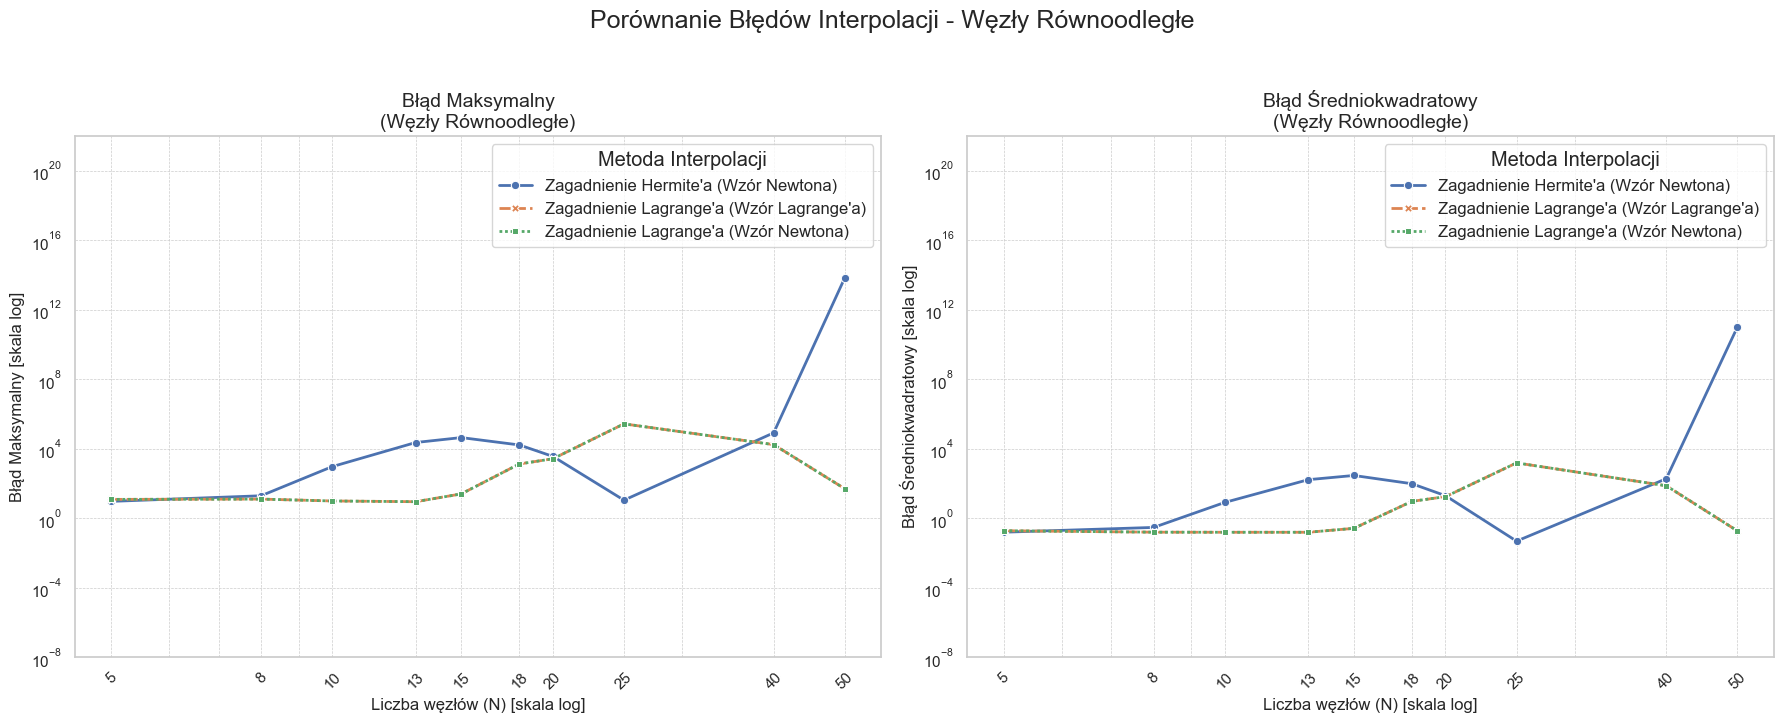

Wykres błędów dla węzłów 'Czebyszewa' zapisany w: ./wykresy_bledow_porownanie\wykres_bledow_Czebyszewa.png


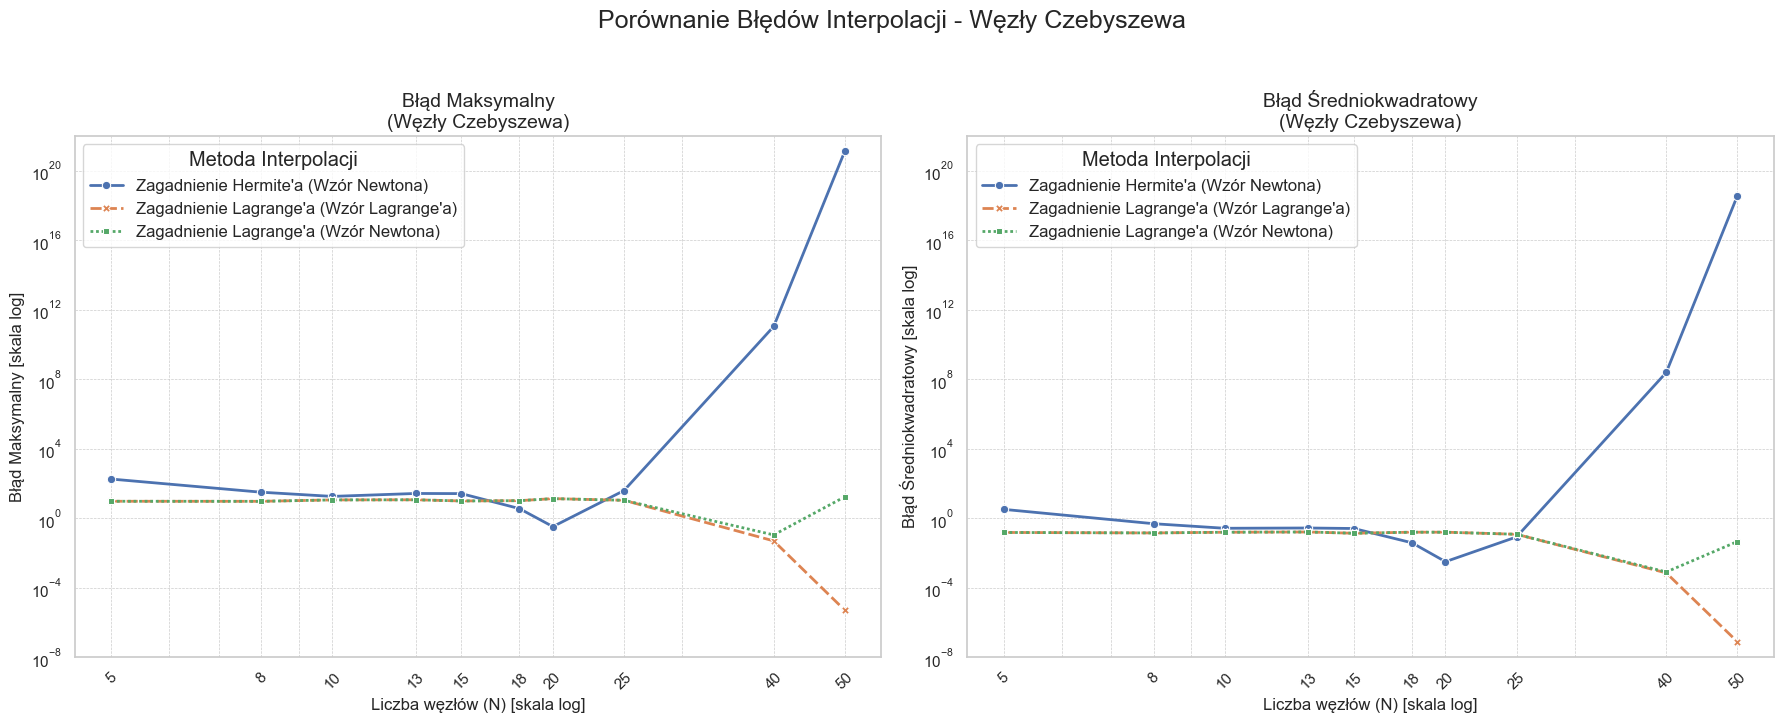


Finished generating plots.


In [8]:
# --- Configuration ---
# Use the path where test.ipynb saves its data
file_path = ".\\data_comparison\\interpolation_comparison_errors.csv"
# Define the output folder for the error plots
output_folder = "./wykresy_bledow_porownanie"
os.makedirs(output_folder, exist_ok=True)

# --- Data Loading and Preparation ---
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from: {file_path}")
    print("Original columns:", df.columns.tolist())
    print("Data sample:\n", df.head())

except FileNotFoundError:
    print(f"Error: Could not find the file '{file_path}'.")
    print("Please ensure 'test.ipynb' has been run successfully and saved the CSV file.")
    exit() # Stop execution if the file doesn't exist
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    exit()

# Check if the DataFrame is empty
if df.empty:
    print("Error: The loaded DataFrame is empty. Cannot generate plots.")
    exit()

# Rename columns for consistency and clarity (adjust if column names in CSV differ)
# These names match the data_records keys used in test.ipynb
df.rename(
    columns={
        "Number of Nodes": "N",
        "Node Type": "Node Type", # Keep as is
        "Interpolation Method": "Interpolation Method", # Keep as is
        "Max Error": "Max Error", # Keep as is
        "Scaled RMSE": "Scaled RMSE", # Keep as is
    },
    inplace=True,
)

# Ensure correct data types
# 'N' should be integer
df["N"] = df["N"].astype(int)

metric_names= {
  'Max Error': "Błąd Maksymalny",
  'Scaled RMSE': "Błąd Średniokwadratowy"
}

# Error columns might contain 'inf' or 'nan' strings from the saving process,
# or could be objects if read_csv couldn't parse them directly.
# Convert them to numeric, coercing errors to NaN (Not a Number)
error_metrics_original_names = ["Max Error", "Scaled RMSE"]
for metric in error_metrics_original_names:
    if metric in df.columns:
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
    else:
        print(f"Warning: Column '{metric}' not found in the DataFrame.")
        # Remove missing metrics from the list to avoid errors later
        error_metrics_original_names.remove(metric)


# Filter out rows where error metrics are NaN, as they cannot be plotted
# Or handle NaN later during plotting if preferred (seaborn often ignores NaNs)
# df.dropna(subset=error_metrics_original_names, inplace=True)

print("\nColumns after renaming and type conversion:", df.columns.tolist())
print("Data types:\n", df.dtypes)
print("Data sample after processing:\n", df.head())

# --- Plotting Setup ---
sns.set(style="whitegrid")

# Separate dataframes based on Node Type
# Use the exact names generated by test.ipynb: "Równoodległe", "Czebyszewa"
node_type_uniform = "Równoodległe"
node_type_chebyshev = "Czebyszewa"

df_uniform = df[df["Node Type"] == node_type_uniform].copy()
df_cheb = df[df["Node Type"] == node_type_chebyshev].copy()

# Check if filtering resulted in empty dataframes
if df_uniform.empty:
    print(f"Warning: No data found for Node Type '{node_type_uniform}'. Skipping plot.")
if df_cheb.empty:
    print(f"Warning: No data found for Node Type '{node_type_chebyshev}'. Skipping plot.")


# Use the potentially updated list of available error metrics
error_metrics_to_plot = error_metrics_original_names

# --- Plotting Function ---
def plot_errors_for_node_type(df_node, node_label):
    """
    Generates and saves error plots for a specific node type.

    Args:
        df_node (pd.DataFrame): DataFrame filtered for a specific node type.
        node_label (str): Label for the node type (e.g., "Równoodległe").
    """
    if df_node.empty:
        print(f"Skipping plot for '{node_label}' as the DataFrame is empty.")
        return

    # Create subplots (1 row, number of metrics columns)
    num_metrics = len(error_metrics_to_plot)
    if num_metrics == 0:
        print(f"No valid error metrics found to plot for '{node_label}'.")
        return

    fig, axes = plt.subplots(1, num_metrics, figsize=(9 * num_metrics, 7), sharey=False)
    # Ensure axes is always an array, even if num_metrics is 1
    if num_metrics == 1:
        axes = [axes]

    # Get unique N values for setting x-axis ticks
    unique_n = sorted(df_node["N"].unique())

    for idx, metric in enumerate(error_metrics_to_plot):
        ax = axes[idx]
        try:
            sns.lineplot(
                data=df_node,
                x="N",
                y=metric,
                hue="Interpolation Method", # Color lines by interpolation method
                style="Interpolation Method", # Use different styles/markers
                markers=True,
                dashes=True, # Use dashes to differentiate further if needed
                ax=ax,
                linewidth=2 # Slightly thicker lines
            )

            # Set scales: log for x-axis (number of nodes often increases exponentially)
            # and log for y-axis (errors often span orders of magnitude)
            ax.set_xscale("log")
            ax.set_yscale("log") # Use log scale for errors

            # Set x-axis ticks to actual N values used for better readability on log scale
            ax.set_xticks(unique_n)
            # Use ScalarFormatter to avoid scientific notation for ticks if not necessary
            ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())
            # ax.get_xaxis().get_major_formatter().set_scientific(False) # Alternative way
            # ax.get_xaxis().get_major_formatter().set_useOffset(False) # Alternative way
            ax.set_xticklabels([str(x) for x in unique_n]) # Label ticks with N values
            ax.tick_params(axis='x', rotation=45) # Rotate labels if they overlap

            # Improve y-axis tick formatting for log scale if needed
            # ax.yaxis.set_major_formatter(mticker.LogFormatterSciNotation()) # Optional: Force sci notation if needed


            # Titles and labels
            ax.set_title(f"{metric_names[metric]}\n(Węzły {node_label})", fontsize=14)
            ax.set_xlabel("Liczba węzłów (N) [skala log]", fontsize=12)
            ax.set_ylim(10e-9,10e21)
            # ax.set_ylim(10e-3,10e21)
            ax.set_ylabel(f"{metric_names[metric]} [skala log]", fontsize=12) # Indicate log scale on y-axis label
            ax.legend(title="Metoda Interpolacji", fontsize='medium', title_fontsize='large') # Adjust legend size
            ax.grid(True, which="both", linestyle='--', linewidth=0.5) # Grid for both major and minor ticks

            # Remove default fixed ylim from the example - let matplotlib autoscale
            # ax.set_ylim(bottom=1e-16) # Optional: set a small bottom limit for log scale if zero errors are possible but unlikely

        except Exception as plot_error:
             print(f"Error plotting metric '{metric}' for node type '{node_label}': {plot_error}")
             ax.set_title(f"Error plotting {metric}\n(Węzły {node_label})", fontsize=14)


    plt.suptitle(f"Porównanie Błędów Interpolacji - Węzły {node_label}", fontsize=18, y=1.03) # Overall title
    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to prevent overlap

    # Save the figure
    output_filename = f"wykres_bledow_{node_label.replace(' ', '_')}.png"
    output_path = os.path.join(output_folder, output_filename)
    try:
        plt.savefig(output_path, bbox_inches='tight') # Use bbox_inches='tight' to include legends properly
        print(f"Wykres błędów dla węzłów '{node_label}' zapisany w: {output_path}")
    except Exception as save_error:
        print(f"Error saving plot '{output_path}': {save_error}")

    plt.show() # Display the plot
    plt.close(fig) # Close the figure to free memory

# --- Generate Plots ---
print("\nGenerating plots...")
plot_errors_for_node_type(df_uniform, node_type_uniform)
plot_errors_for_node_type(df_cheb, node_type_chebyshev)

print("\nFinished generating plots.")